In [1]:
import re
import unicodedata
import pandas as pd
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import prepare
import acquire
import env

1. Spam Data

- Load the spam data set.

In [2]:
def get_spam_data():
    url = env.get_db_url('spam_db')
    sql = "SELECT * FROM spam"

    df = pd.read_sql(sql, url, index_col="id")
    return df

In [3]:
df = get_spam_data()

In [4]:
df

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."


In [5]:
def clean_data(text):
    ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [6]:
ham_corpus = clean_data(' '.join(df[df.label == 'ham'].text))
spam_corpus = clean_data(' '.join(df[df.label == 'spam'].text))
all_corpus = clean_data(' '.join(df.text))

In [7]:
ham_freq = pd.Series(ham_corpus).value_counts()
spam_freq = pd.Series(spam_corpus).value_counts()
all_freq = pd.Series(all_corpus).value_counts()

In [8]:
all_freq

call             600
im               462
get              397
ur               384
go               304
                ... 
cage               1
surrounded         1
cuck               1
weeddeficient      1
bitching           1
Length: 8900, dtype: int64

- Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [9]:
def make_bigrams(s, n = 2):
    return (pd.Series(nltk.ngrams(s, n))).value_counts()

make_bigrams(ham_corpus)

(call, later)     52
(ill, call)       48
(let, know)       42
(sorry, ill)      39
(dont, know)      32
                  ..
(cant, ever)       1
(master, cant)     1
(dont, master)     1
(biro, dont)       1
(true, name)       1
Length: 30869, dtype: int64

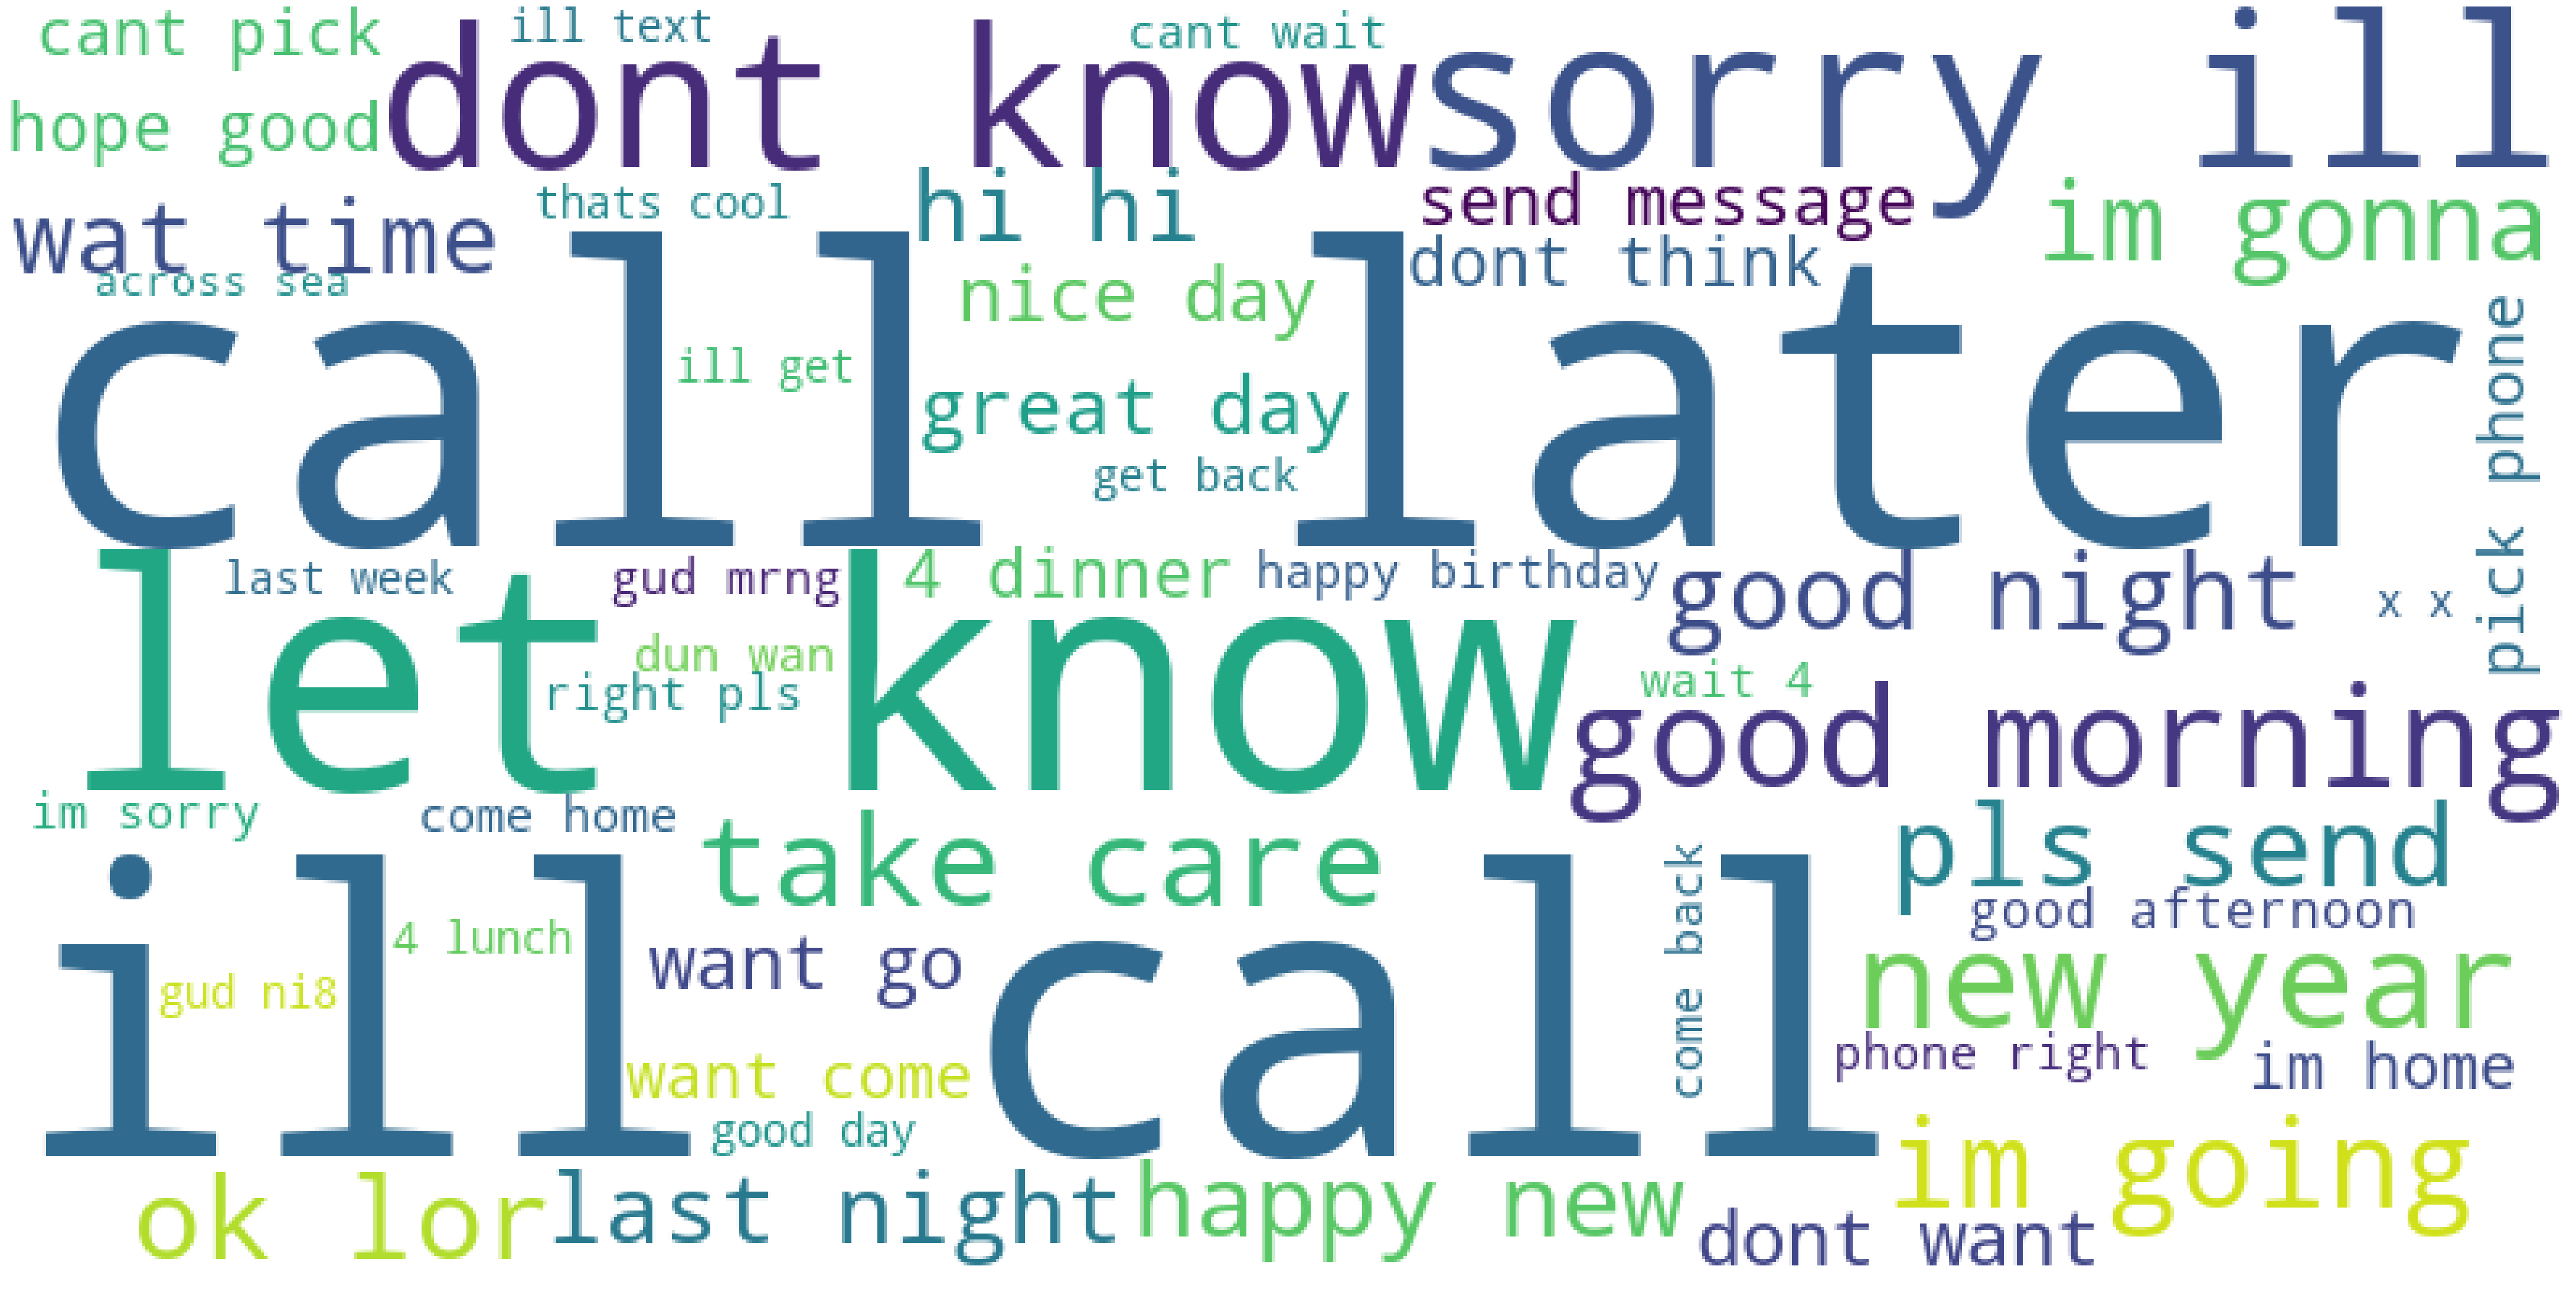

In [10]:
def make_bigram_cloud(s, top = 20, width = 800, height = 400):
    """ s = series of bigram count """
    data = {' '.join(k) : v for k, v in s.nlargest(top).to_dict().items()}
    img = WordCloud(background_color = 'white', width = width, height = height).generate_from_frequencies(data)
    plt.figure(figsize=(width/10, height/10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

make_bigram_cloud(make_bigrams(ham_corpus), top = 50)

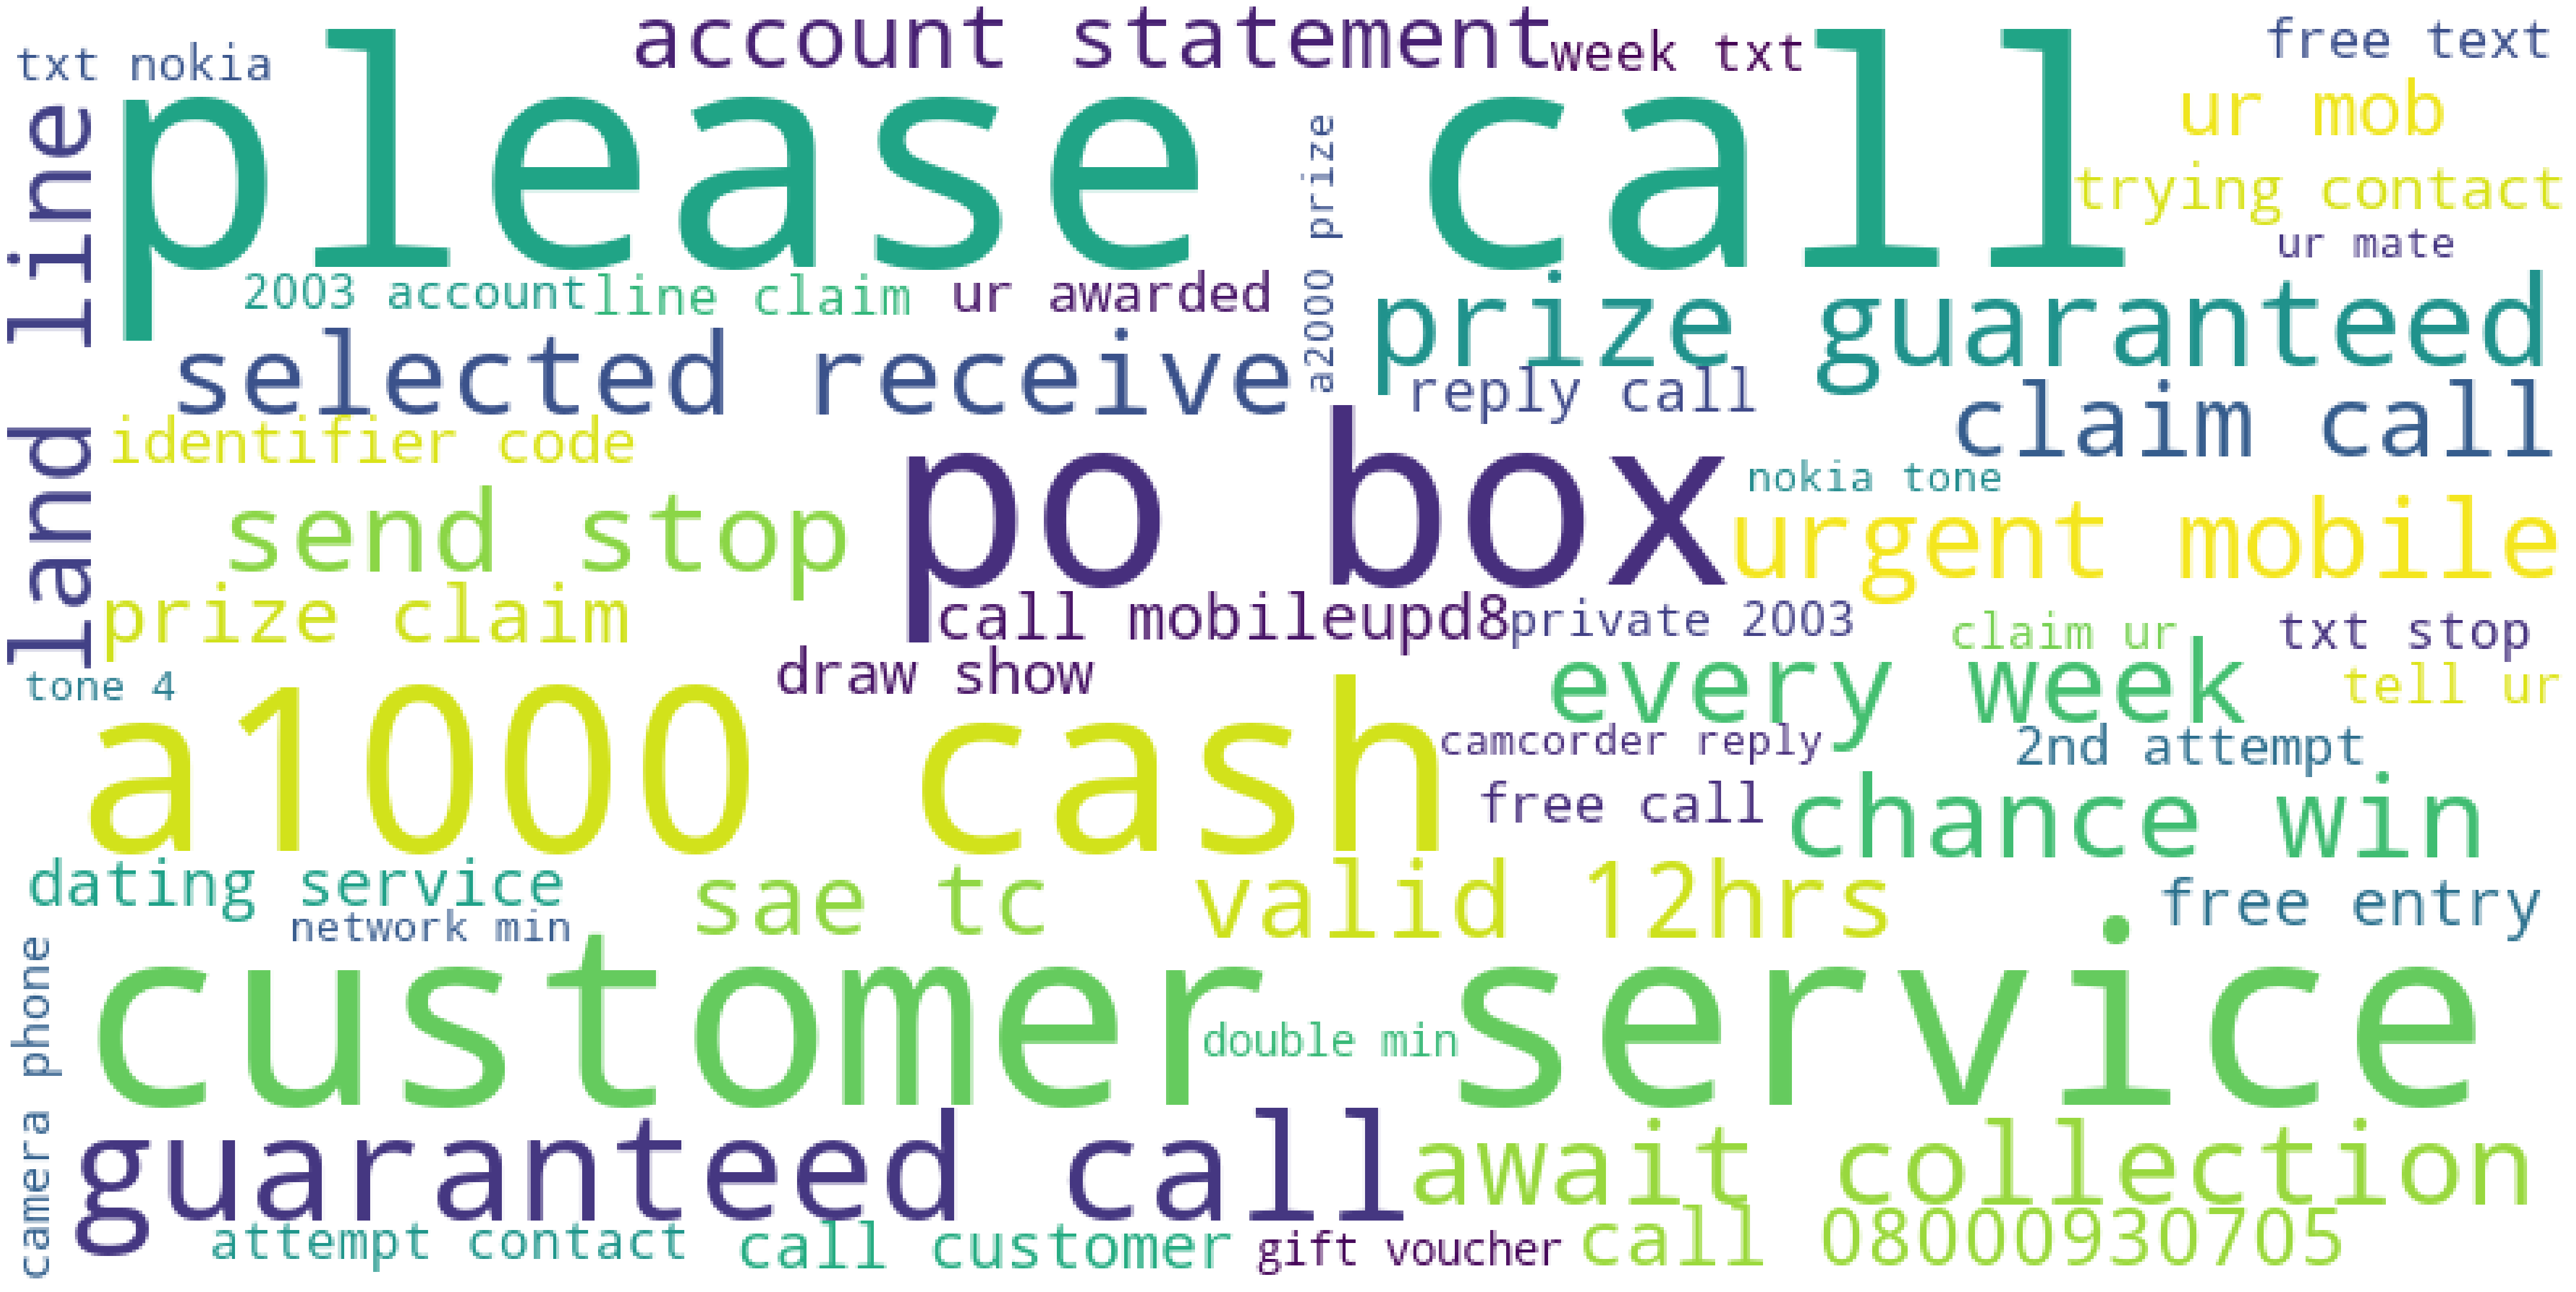

In [11]:
make_bigram_cloud(make_bigrams(spam_corpus), top = 50)

- Is there any overlap in the bigrams for the spam data and the ham data?

In [12]:
all_corpus_bigrams = pd.DataFrame({'all_corpus':make_bigrams(all_corpus)})
ham_corpus_bigrams = pd.DataFrame({'ham_corpus':make_bigrams(ham_corpus)})
spam_corpus_bigrams = pd.DataFrame({'spam_corpus':make_bigrams(spam_corpus)})

In [13]:
all_and_ham = all_corpus_bigrams.join(ham_corpus_bigrams, how = 'left')
bigram_counts = all_and_ham.join(spam_corpus_bigrams, how='left').fillna(0)

In [14]:
#183 of the bigrams overlap
bigram_counts[(bigram_counts.ham_corpus != 0) & (bigram_counts.spam_corpus != 0)]

,all_corpus,ham_corpus,spam_corpus
"(please, call)",53,9.0,44.0
"(dont, know)",38,32.0,6.0
"(new, year)",32,30.0,2.0
"(customer, service)",29,2.0,27.0
"(po, box)",25,1.0,24.0
...,...,...,...
"(next, month)",2,1.0,1.0
"(could, meet)",2,1.0,1.0
"(today, ur)",2,1.0,1.0
"(tomorrow, ur)",1,1.0,1.0


- Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [15]:
def make_compare_df(n_gram = 3):
    ham_corpus = clean_data(' '.join(df[df.label == 'ham'].text))
    spam_corpus = clean_data(' '.join(df[df.label == 'spam'].text))
    all_corpus = clean_data(' '.join(df.text))
    all_corpus_ngrams = pd.DataFrame({'all_corpus':make_bigrams(all_corpus, n = n_gram)})
    ham_corpus_ngrams = pd.DataFrame({'ham_corpus':make_bigrams(ham_corpus, n = n_gram)})
    spam_corpus_ngrams = pd.DataFrame({'spam_corpus':make_bigrams(spam_corpus, n = n_gram)})
    all_and_ham = all_corpus_ngrams.join(ham_corpus_ngrams, how = 'left')
    ngram_counts = all_and_ham.join(spam_corpus_ngrams, how='left').fillna(0)
    return ngram_counts

def find_overlap(df):
    return df[(df.ham_corpus != 0) & (df.spam_corpus != 0)]

def make_barchart(df):
    sns.countplot(x=df.index)

In [16]:
make_compare_df(n_gram=3)

,all_corpus,ham_corpus,spam_corpus
"(ill, call, later)",42,42.0,0.0
"(sorry, ill, call)",38,38.0,0.0
"(prize, guaranteed, call)",21,0.0,21.0
"(happy, new, year)",19,19.0,0.0
"(call, customer, service)",15,0.0,15.0
...,...,...,...
"(bed, throw, laundry)",1,1.0,0.0
"(throw, laundry, top)",1,1.0,0.0
"(laundry, top, cant)",1,1.0,0.0
"(top, cant, friend)",1,1.0,0.0


In [17]:
find_overlap(make_compare_df(n_gram=3))

,all_corpus,ham_corpus,spam_corpus
"(please, call, back)",5,1.0,4.0
"(sorry, missed, call)",3,2.0,1.0
"(number, im, glad)",2,1.0,1.0
"(new, year, eve)",2,1.0,1.0
"(called, left, message)",2,1.0,1.0


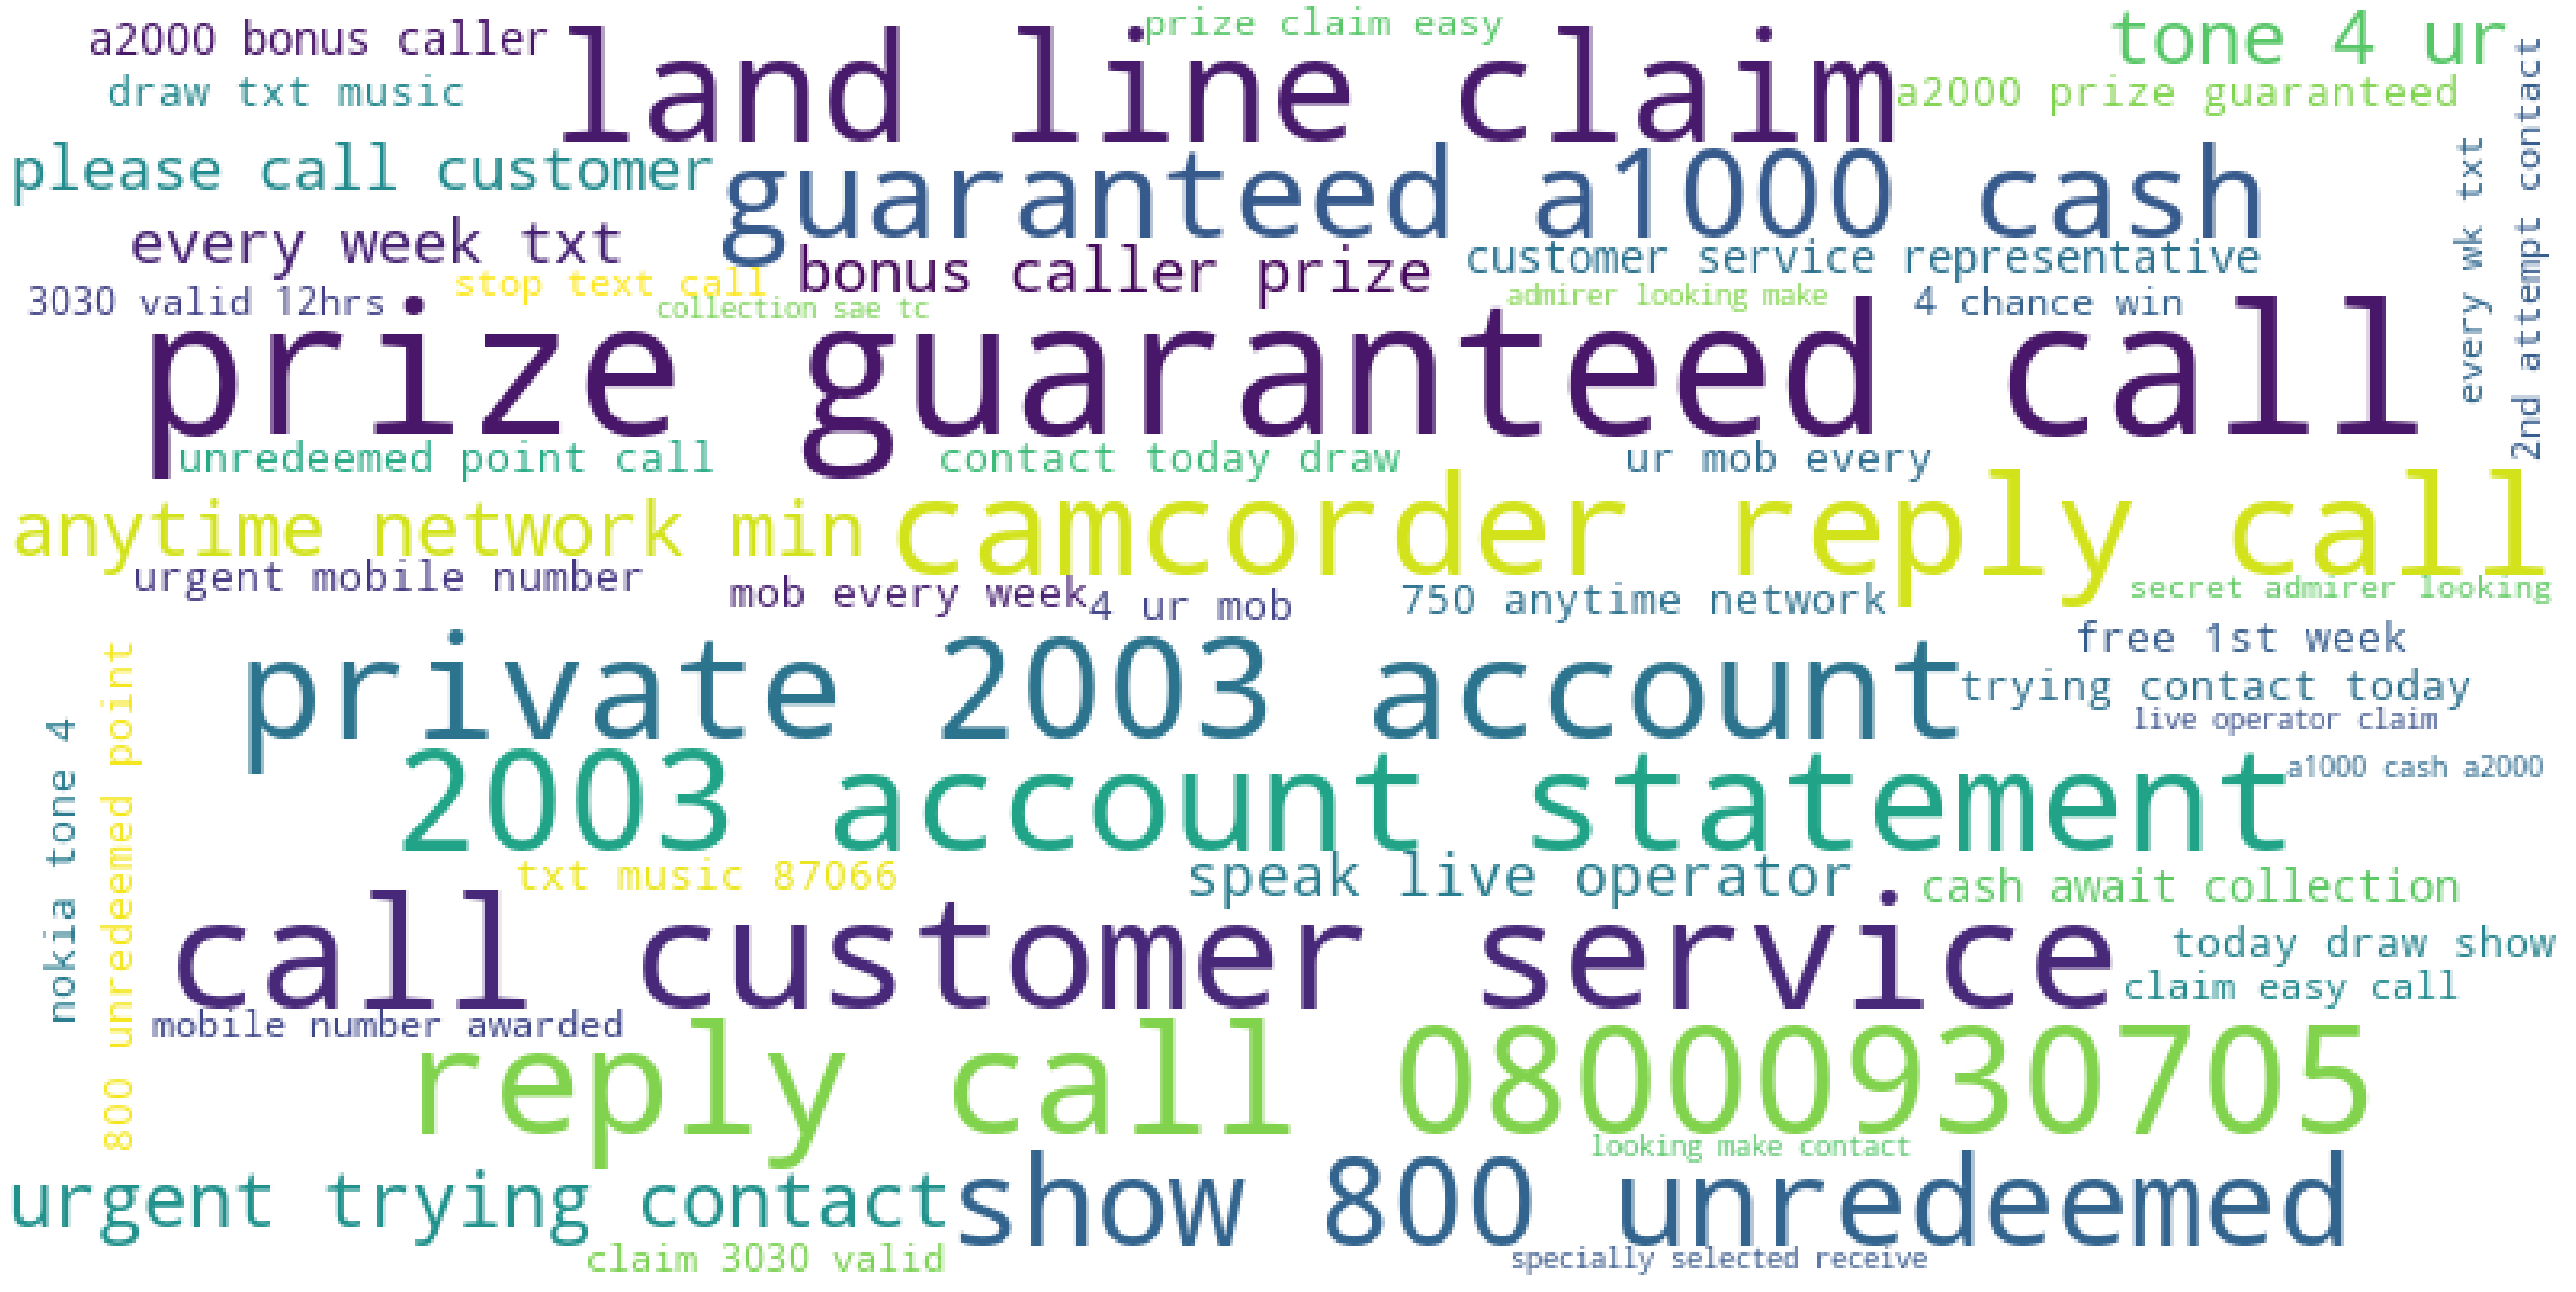

In [18]:
make_bigram_cloud(make_bigrams(spam_corpus, n = 3), top = 50)

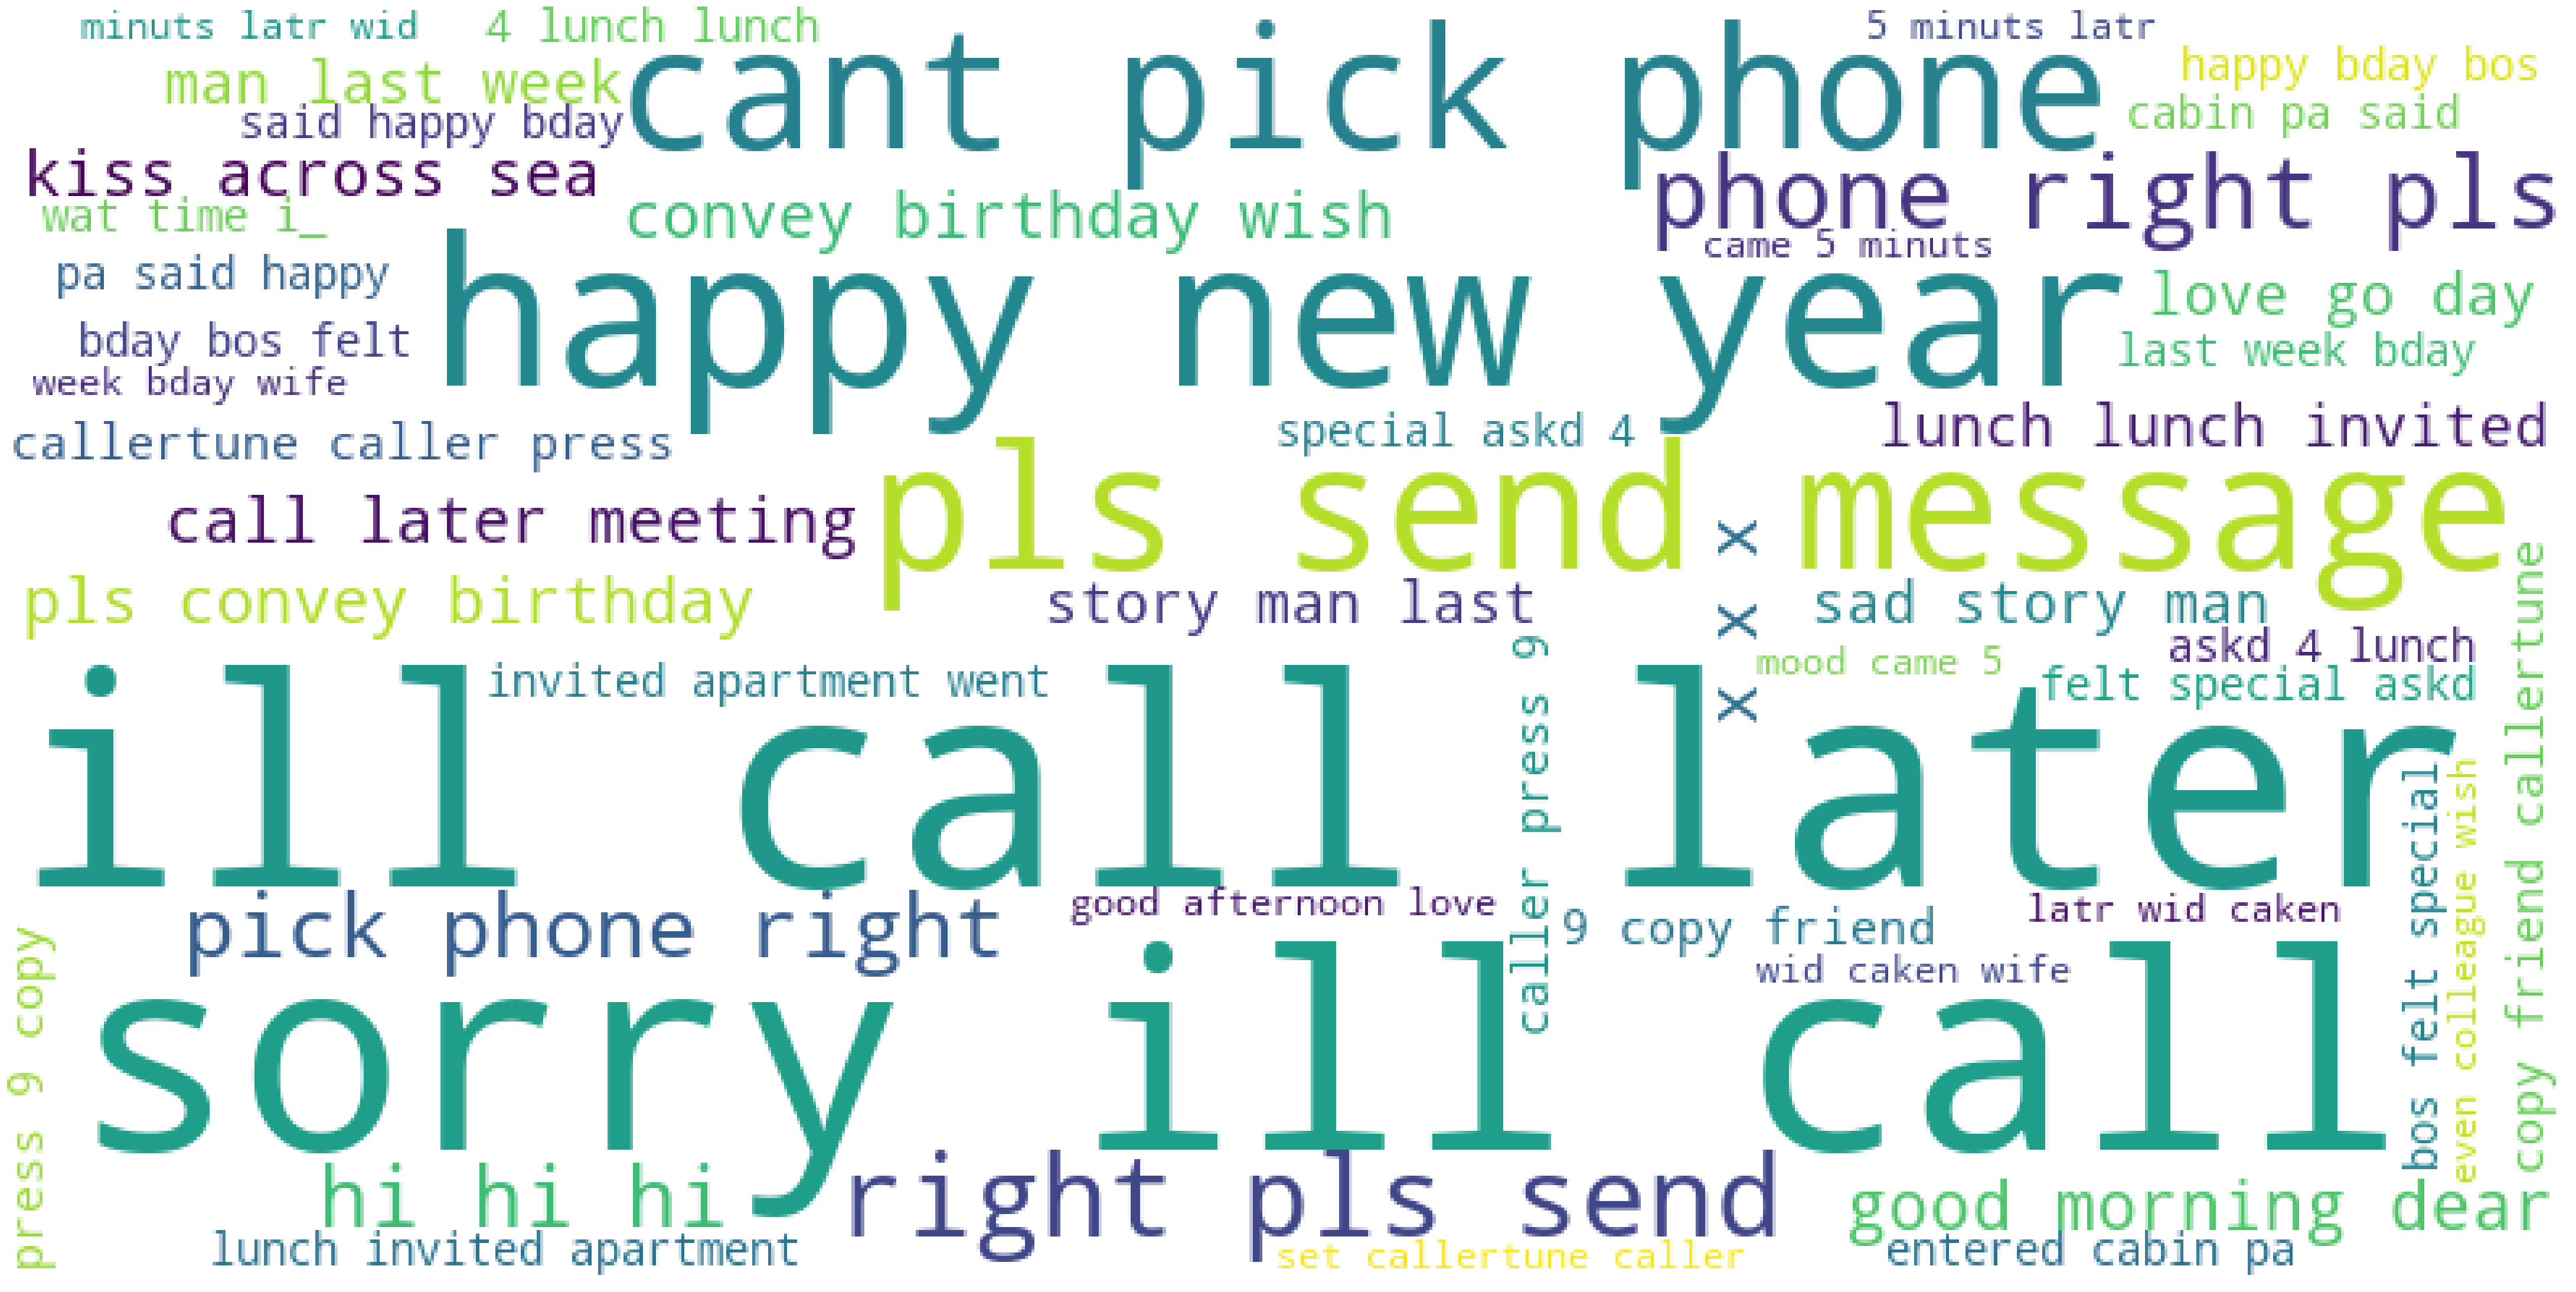

In [19]:
make_bigram_cloud(make_bigrams(ham_corpus, n = 3), top = 50)

<AxesSubplot:>

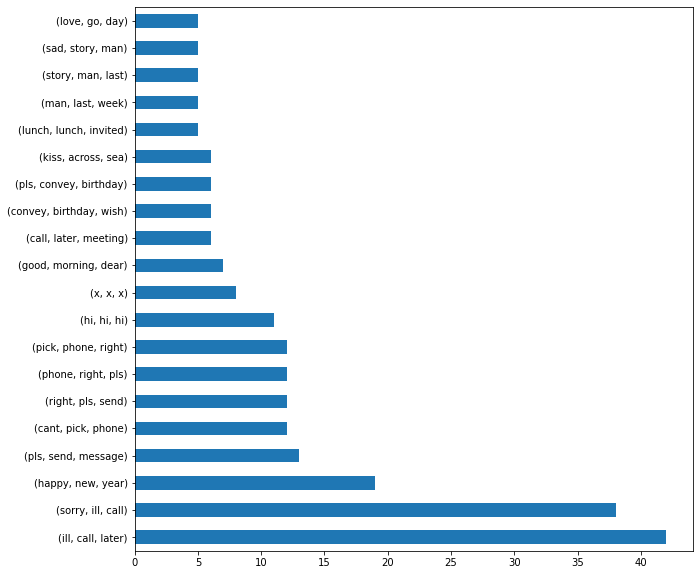

In [20]:
plt.figure(figsize=(10,10))
make_bigrams(ham_corpus, n = 3).nlargest(20).plot.barh()

2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [23]:
blog_df = prepare.make_dataframe(acquire.read_url_or_file_codeup())

Found File


In [24]:
blog_df.sample(2)

,title,content,clean,stemmed,lemmatized
9,is our cloud administration program right for you,changing careers can be scary the first thing ...,"[changing, careers, scary, first, thing, may, ...","[chang, career, scari, first, thing, may, ask,...","[changing, career, scary, first, thing, may, a..."
20,learn to code html css on 430,html css are the design building blocks of al...,"[html, css, design, building, blocks, websites...","[html, css, design, build, block, websit, inte...","[html, cs, design, building, block, website, i..."


In [57]:
blog_corpus = ' '.join([' '.join(x) for x in (blog_df['clean'].tolist())]).split()
blog_corpus_lemma = ' '.join([' '.join(x) for x in (blog_df['lemmatized'].tolist())]).split()

In [62]:
blog_corpus_freq = pd.Series(blog_corpus).value_counts()

In [61]:
blog_lemma_freq = pd.Series(blog_corpus_lemma).value_counts()

<AxesSubplot:>

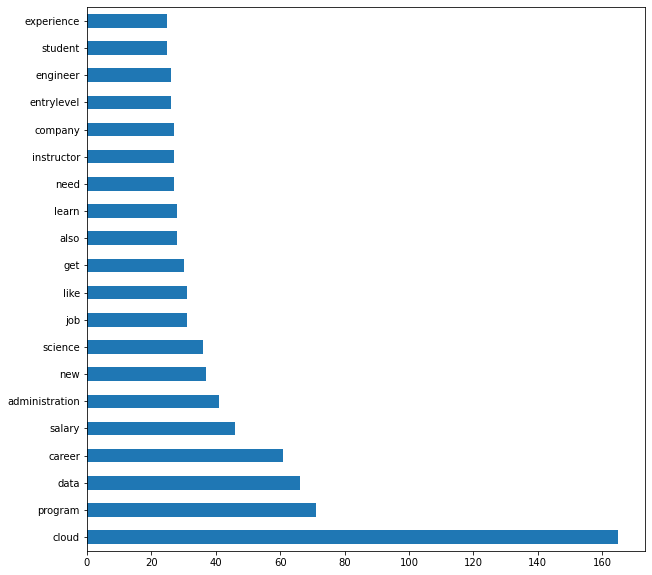

In [64]:
#blog is pushing the cloud academy
plt.figure(figsize=(10,10))
blog_lemma_freq.nlargest(20).plot.barh()

<AxesSubplot:>

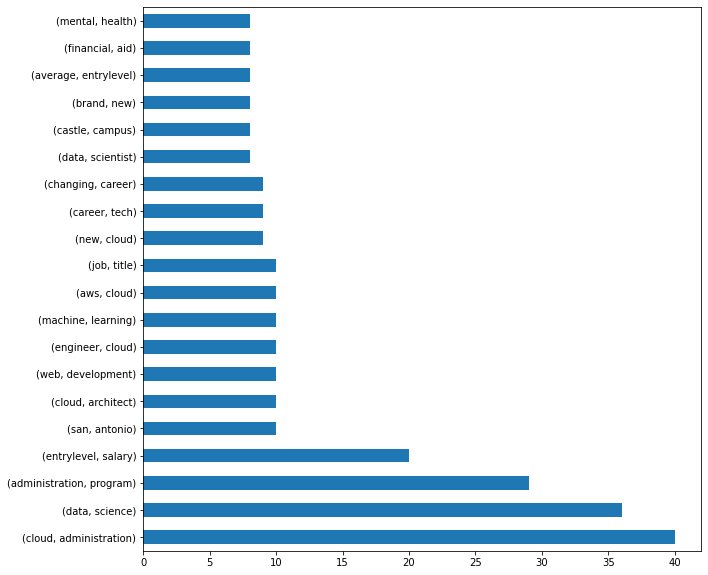

In [69]:
#blog is pushing the cloud admin and data science
plt.figure(figsize=(10,10))
make_bigrams(blog_corpus_lemma).nlargest(20).plot.barh()

3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.